# Avaliação de Decision Trees para as seleções propostas (abordagem 1)

### 1. Carregando os dados e pré-processamento dos dados

In [1]:
# Manipulação dos dados
import numpy  as np
import scipy  as sp
import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn           as sns
%matplotlib inline

In [2]:
# Importando o classificador
from sklearn.tree import DecisionTreeClassifier as DT

In [3]:
# Conjunto de treinamento e teste - normal
dados = pd.read_csv('../../Dados/abordagem1.csv')

In [4]:
# Pré-processamento dos dados
dados.replace(['TB+','TB-','Sim','Não','Branco','Não branco','Positivo','Negativo','ignorado','Masculino','Feminino'],[1,0,1,-1,1,-1,1,-1,0,1,-1],inplace=True)
dados.Idade.replace(999,45,inplace=True)
dados.Idade = (dados.Idade - np.mean(dados.Idade))/np.std(dados.Idade)

In [134]:
sm = SMOTE(ratio='minority',random_state=0,n_jobs=-1)

### 2. Treinamento para a seleção utilizando qui-quadrado

In [5]:
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.model_selection import cross_val_score
from sklearn.metrics         import roc_auc_score

# verificar o balanceamento
from collections import Counter

In [6]:
# Features selecionadas 
features_chi2 = ['Perda_peso_10percent', 'Semanas_tosse', 'Sudorese_noturna', 'Febre','Estado_civil_Solteiro', 'Estado_civil_Casado', 'Dispnéia', 'Sexo',
                 'Delegacia_2anos', 'Estado_civil_viúvo', 'Cicatriz_BCG', 'Expectoração','Prisão_2anos','Idade','desfecho']

In [7]:
y = dados[features_chi2].desfecho
X = dados[features_chi2].drop(['desfecho'],axis=1)

In [8]:
# Balanceamento das classes
Counter(y)

Counter({0: 1856, 1: 871})

In [9]:
# Procedimento de Nested K-fold Cross-validation

# Garante a representação da classe minoritária em cada fold; estratificada
kf = SKF(n_splits=10,random_state = 0, shuffle=True)

dict_test = dict()
dict_val  = dict()

for k in list(range(1,51,1)):
    
    dt = DT(max_depth=k)
    
    # armazena os scores de validação para um determinado parâmetro
    val_scores  = []
    test_scores = []
    
    for train_index, test_index in kf.split(X,y):
        
#         # Divide o treino em dados e target
#         y_train = y_res.loc[train_index]
#         X_train = X_res.loc[train_index]

        y_train = y.loc[train_index]
        X_train = X.loc[train_index]
        
        # Armazena os valores da validação cruzada (interna)
        val_scores.extend(cross_val_score(dt,X_train,y_train,cv=10,scoring='roc_auc'))
        
        # Treinamento com o conjunto de dados k-fold externo
#         X_test = X_res.loc[test_index]
#         y_test = y_res.loc[test_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        # Score de treinamento
        y_pred = dt.fit(X_train,y_train).predict(X_test)
        test_scores.append(roc_auc_score(y_test,y_pred))
        
        # Armazenar em um vetor de treino; busca por dict
        
        
    dict_test[k] = test_scores 
    dict_val[k]  = val_scores  

In [10]:
# Resultados 

validacao = list(dict_val.values())
teste = list(dict_test.values())

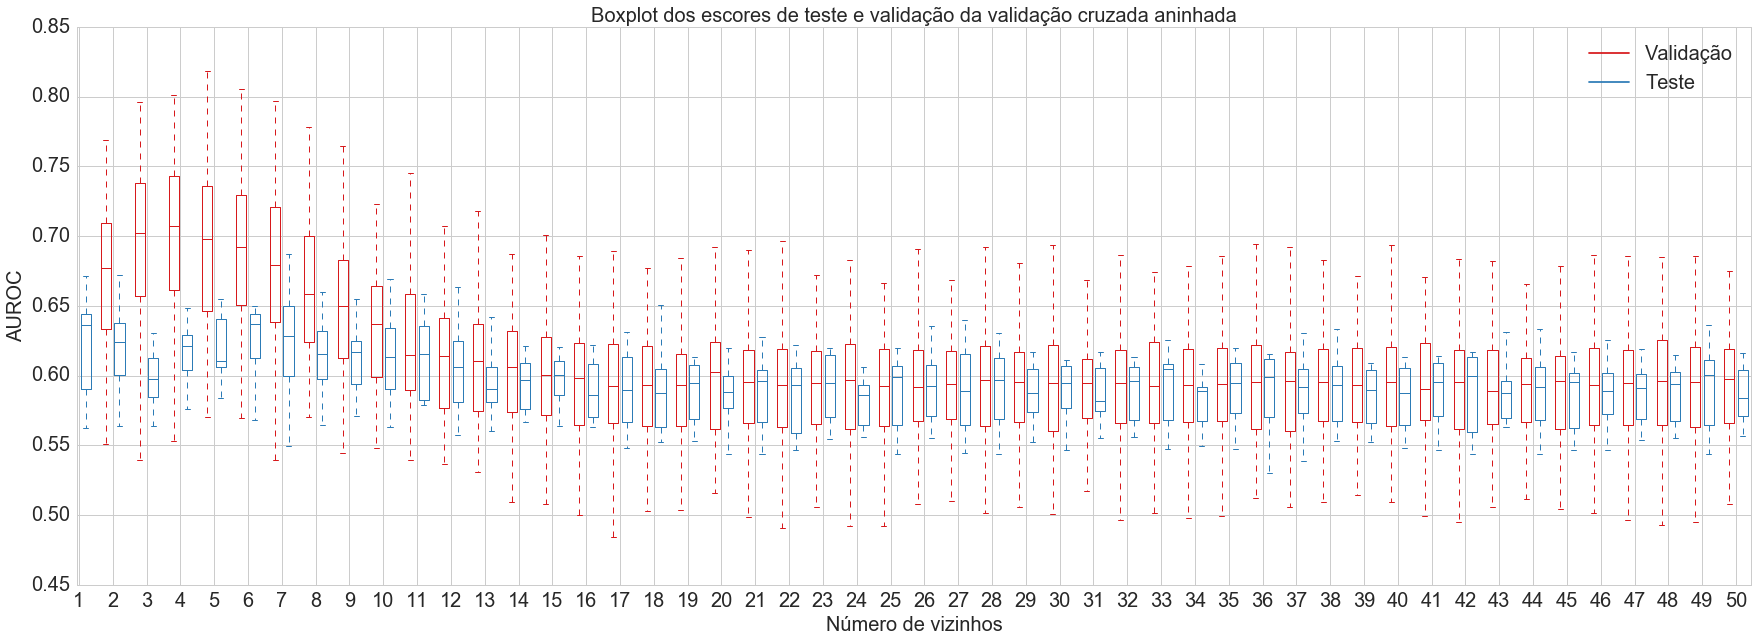

In [11]:
sns.set_style('whitegrid')
ticks = list(range(1,51))

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(30,10))

bpl = plt.boxplot(validacao, positions=np.array(range(len(validacao)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(teste, positions=np.array(range(len(teste)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Validação')
plt.plot([], c='#2C7BB6', label='Teste')
plt.legend(fontsize=20)

plt.title('Boxplot dos escores de teste e validação da validação cruzada aninhada',fontsize=20)
plt.xticks(range(0, len(ticks) * 2, 2), ticks,fontsize=20)
plt.ylabel('AUROC',fontsize=20)
plt.xlabel('Número de vizinhos',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
np.mean(cross_val_score(DT(max_depth=24),X,y,cv=10))

0.6439602904609345

### 3. Resultados para a seleção utilizando random forest

In [12]:
features_rf = ['Perda_peso_10percent', 'Febre', 'Idade', 'Sexo', 'Semanas_tosse', 'Estado_civil_Solteiro',
               'Sudorese_noturna', 'Prisão_2anos', 'Perda_de_apetite', 'Estado_civil_Casado', 'Delegacia_2anos','desfecho']

In [13]:
y = dados[features_rf].desfecho
X = dados[features_rf].drop(['desfecho'],axis=1)

In [14]:
# Procedimento de Nested K-fold Cross-validation

# Garante a representação da classe minoritária em cada fold; estratificada
kf = SKF(n_splits=10,random_state = 0, shuffle=True)

dict_test = dict()
dict_val  = dict()

for k in list(range(1,51)):
    
    dt = DT(max_depth=k)
    
    # armazena os scores de validação para um determinado parâmetro
    val_scores  = []
    test_scores = []
    

    
    for train_index, test_index in kf.split(X,y):
        
#         # Divide o treino em dados e target
#         y_train = y_res.loc[train_index]
#         X_train = X_res.loc[train_index]

        y_train = y.loc[train_index]
        X_train = X.loc[train_index]
        
        # Armazena os valores da validação cruzada (interna)
        val_scores.extend(cross_val_score(dt,X_train,y_train,cv=10,scoring='roc_auc'))
        
        # Treinamento com o conjunto de dados k-fold externo
#         X_test = X_res.loc[test_index]
#         y_test = y_res.loc[test_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        # Score de treinamento
        y_pred = dt.fit(X_train,y_train).predict(X_test)
        test_scores.append(roc_auc_score(y_test,y_pred))
        
        # Armazenar em um vetor de treino; busca por dict
        
        
    dict_test[k] = test_scores 
    dict_val[k]  = val_scores  

In [15]:
# Resultados 

validacao = list(dict_val.values())
teste = list(dict_test.values())

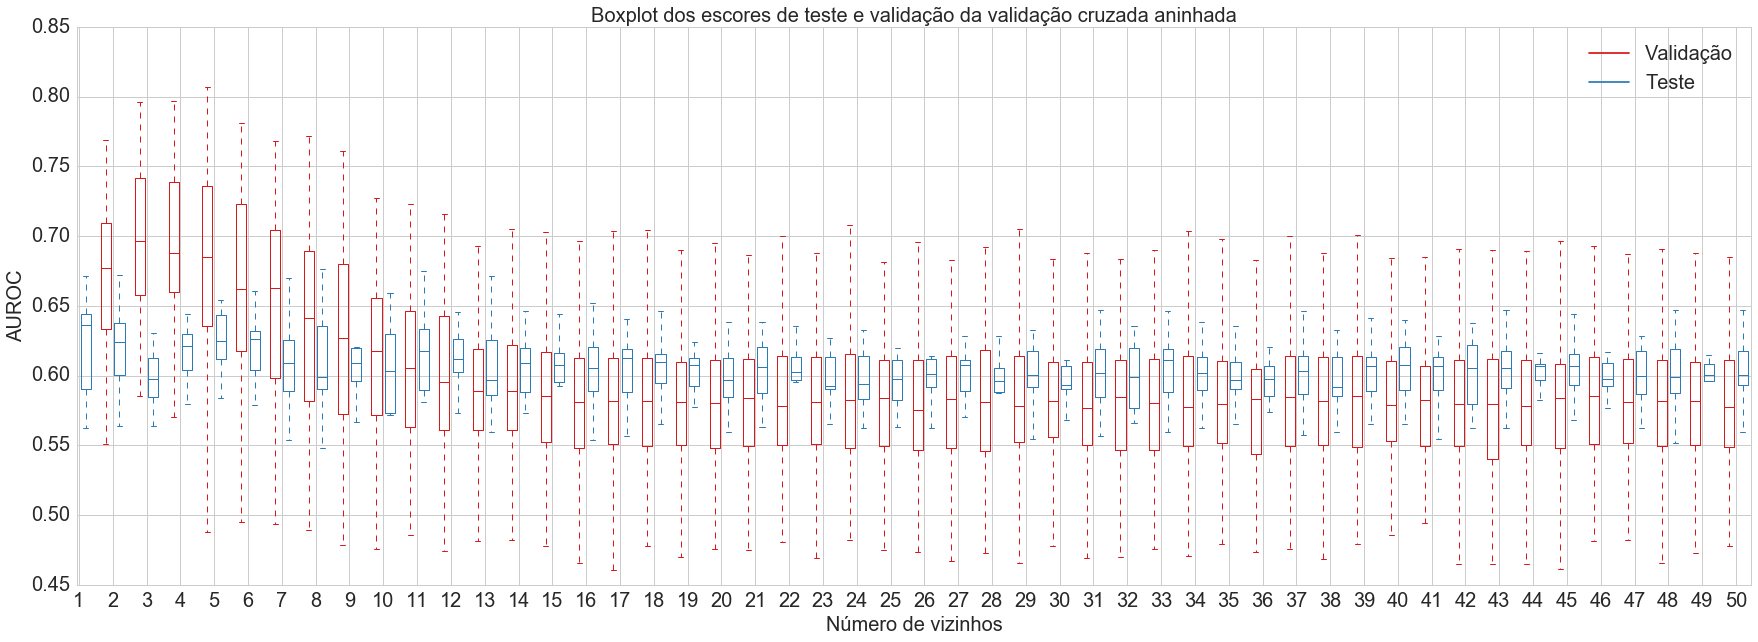

In [16]:
sns.set_style('whitegrid')
ticks = list(range(1,51))

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(30,10))

bpl = plt.boxplot(validacao, positions=np.array(range(len(validacao)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(teste, positions=np.array(range(len(teste)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Validação')
plt.plot([], c='#2C7BB6', label='Teste')
plt.legend(fontsize=20)

plt.title('Boxplot dos escores de teste e validação da validação cruzada aninhada',fontsize=20)
plt.xticks(range(0, len(ticks) * 2, 2), ticks,fontsize=20)
plt.ylabel('AUROC',fontsize=20)
plt.xlabel('Número de vizinhos',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### 4. Resultados para a seleção utilizando regressão logística

In [ ]:
features_log = ['Perda_peso_10percent', 'Febre', 'Idade', 'Sexo', 'Semanas_tosse', 'Estado_civil_Solteiro',
                'Sudorese_noturna', 'Prisão_2anos', 'Perda_de_apetite', 'Estado_civil_Casado', 'Delegacia_2anos','desfecho']

In [ ]:
y = dados[features_log].desfecho
X = dados[features_log].drop(['desfecho'],axis=1)

In [ ]:
# Procedimento de Nested K-fold Cross-validation

# Garante a representação da classe minoritária em cada fold; estratificada
kf = SKF(n_splits=10,random_state = 0, shuffle=True)

dict_test = dict()
dict_val  = dict()

for k in list(range(1,51,2)):
    
    knn = KNN(n_neighbors=k)
    
    # armazena os scores de validação para um determinado parâmetro
    val_scores  = []
    test_scores = []
    

    
    for train_index, test_index in kf.split(X,y):
        
#         # Divide o treino em dados e target
#         y_train = y_res.loc[train_index]
#         X_train = X_res.loc[train_index]

        y_train = y.loc[train_index]
        X_train = X.loc[train_index]
        
        # Armazena os valores da validação cruzada (interna)
        val_scores.extend(cross_val_score(knn,X_train,y_train,cv=10,scoring='roc_auc'))
        
        # Treinamento com o conjunto de dados k-fold externo
#         X_test = X_res.loc[test_index]
#         y_test = y_res.loc[test_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        # Score de treinamento
        y_pred = knn.fit(X,y).predict(X_test)
        test_scores.append(roc_auc_score(y_test,y_pred))
        
        # Armazenar em um vetor de treino; busca por dict
        
        
    dict_test[k] = test_scores 
    dict_val[k]  = val_scores  

In [ ]:
# Resultados 

validacao = list(dict_val.values())
teste = list(dict_test.values())

In [ ]:
sns.set_style('whitegrid')
ticks = list(range(1,51,2))

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(30,10))

bpl = plt.boxplot(validacao, positions=np.array(range(len(validacao)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(teste, positions=np.array(range(len(teste)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Validação')
plt.plot([], c='#2C7BB6', label='Teste')
plt.legend(fontsize=20)

plt.title('Boxplot dos escores de teste e validação da validação cruzada aninhada',fontsize=20)
plt.xticks(range(0, len(ticks) * 2, 2), ticks,fontsize=20)
plt.ylabel('AUROC',fontsize=20)
plt.xlabel('Número de vizinhos',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [147]:
# Procedimento de Nested K-fold Cross-validation

# Garante a representação da classe minoritária em cada fold; estratificada
kf = SKF(n_splits=10,random_state = 0, shuffle=True)

dict_test = dict()
dict_val  = dict()

for k in list(range(1,51,2)):
    
    knn = KNN(n_neighbors=k)
    
    # armazena os scores de validação para um determinado parâmetro
    val_scores  = []
    test_scores = []
    

    
    for train_index, test_index in kf.split(X_res,y_res):
        
        # Divide o treino em dados e target
        y_train = y_res.loc[train_index]
        X_train = X_res.loc[train_index]
        
        # Armazena os valores da validação cruzada (interna)
        val_scores.extend(cross_val_score(knn,X_train,y_train,cv=10,scoring='roc_auc'))
        
        # Treinamento com o conjunto de dados k-fold externo
        X_test = X_res.loc[test_index]
        y_test = y_res.loc[test_index]
        
        # Score de treinamento
        y_pred = knn.fit(X,y).predict(X_test)
        test_scores.append(roc_auc_score(y_test,y_pred))
        
        # Armazenar em um vetor de treino; busca por dict
        
        
    dict_test[k] = test_scores 
    dict_val[k]  = val_scores  